In [38]:
import numpy as np
import glob
import os
import tensorflow as tf
from tensorflow.keras import Sequential 
from tensorflow.keras import preprocessing as ps
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2


In [39]:
img_path = [f'Sp_whole_copy/swimseg/images/{str(i).zfill(4)}.png' for i in range(1, 1014)]
mask_path = [f'Sp_whole_copy/swimseg/GTmaps/{str(i).zfill(4)}_GT.png' for i in range(1, 1014)]

img = tf.data.Dataset.from_tensor_slices(img_path)
mask = tf.data.Dataset.from_tensor_slices(mask_path)

dataset = tf.data.Dataset.zip((img, mask))

def read_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image,(224,224))
    image = tf.cast(image, tf.float32) / 255.0
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.image.resize(mask,(224,224),method='nearest')
    
    return image, mask

dataset_size = len(list(dataset))
train_size = int(0.8 * dataset_size)

train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

train_dataset = train_dataset.map(read_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(read_image_and_mask, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [40]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.1, seed=seed),
            tf.keras.layers.RandomZoom(0.1, seed=seed),
            tf.keras.layers.RandomContrast(0.2, seed=seed),
            tf.keras.layers.RandomBrightness(0.2, seed=seed)
        ])
    self.augment_labels = tf.keras.Sequential([
            tf.keras.layers.RandomContrast(0.2, seed=seed),
            tf.keras.layers.RandomBrightness(0.2, seed=seed)
        ])

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [41]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = int((0.8*dataset_size) // BATCH_SIZE)

In [42]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

In [43]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

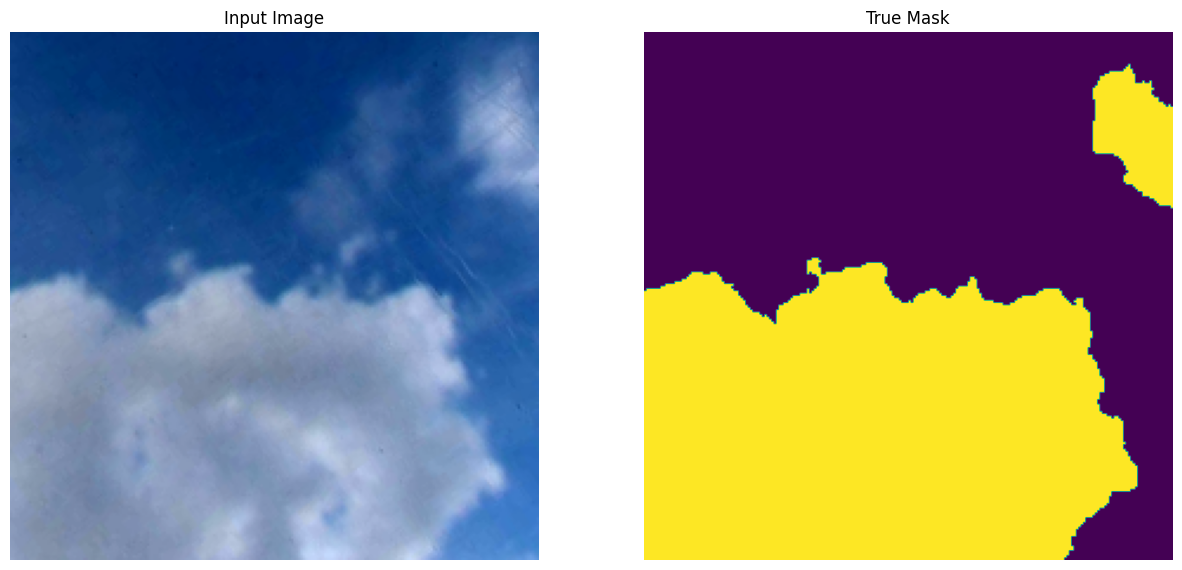

In [44]:
for images, masks in train_batches.take(1):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [45]:
base_model = tf.keras.applications.MobileNetV3Large(input_shape=[224, 224, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'expanded_conv/project/BatchNorm',   # 112x112
    'expanded_conv_2/project/BatchNorm', # 56x56
    'expanded_conv_5/project/BatchNorm', # 28x28
    'expanded_conv_9/project/BatchNorm', # 14x14
    'expanded_conv_12/project',          # 7x7
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [46]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [47]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3), 
    upsample(32,3)   # 32x32 -> 64x64
]

In [48]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[224, 224, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [58]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [59]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  
  return pred_mask[0]

In [60]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


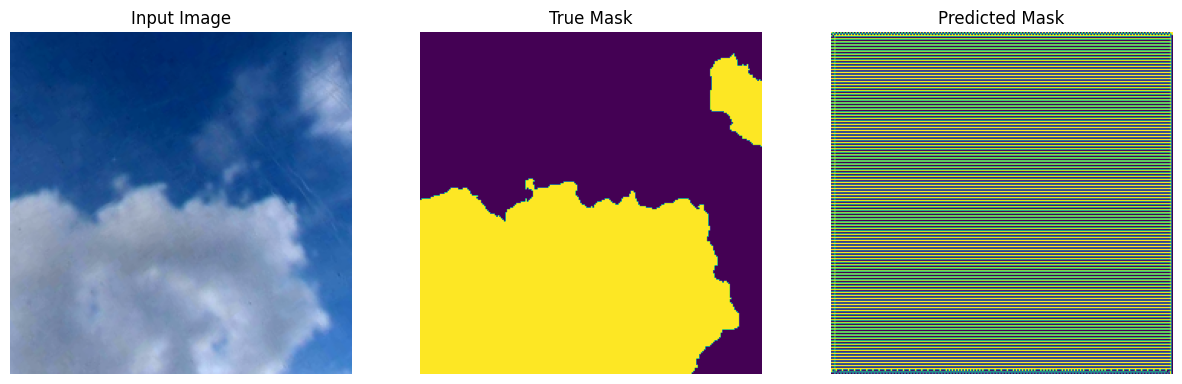

In [61]:
show_predictions()

In [62]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(dataset=train_batches)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 332ms/step


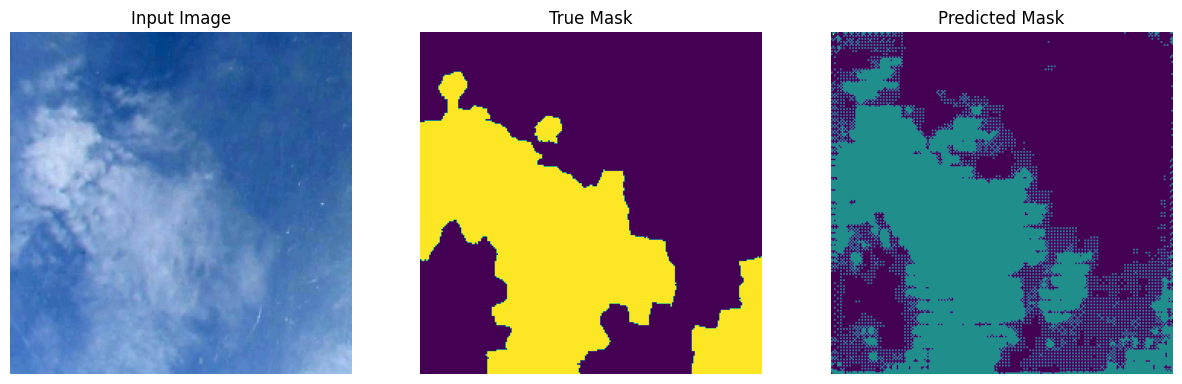


Sample Prediction after epoch 24

101/101 [==============================] - 10s 100ms/step - loss: 0.4140 - accuracy: 0.8242 - val_loss: 0.5336 - val_accuracy: 0.7905


In [63]:
EPOCHS = 150
VAL_SUBSPLITS = 3
VALIDATION_STEPS = int((0.2*dataset_size)//BATCH_SIZE//VAL_SUBSPLITS)

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback(),tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,mode='min')])

In [64]:
model.evaluate(test_batches)

26/26 [==============================] - 1s 45ms/step - loss: 0.5620 - accuracy: 0.7420


[0.5619828701019287, 0.7420011758804321]

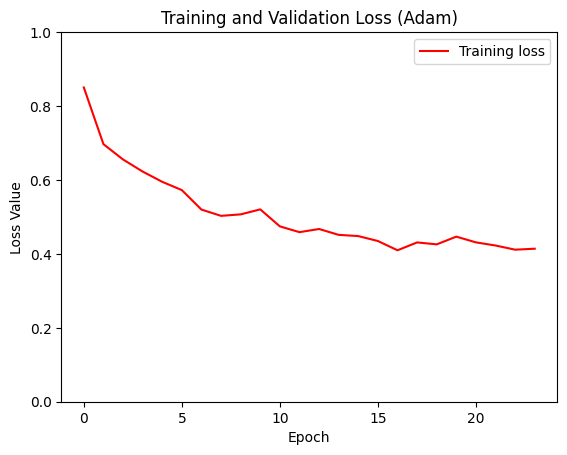

In [65]:
loss = model_history.history['loss']
#val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
#plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss (Adam)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [67]:
model.save('seg11_mbnV3SGD.h5')